# setup

In [79]:
from ollama import Client

base_url = "http://host.docker.internal:11434"

client = Client(
  host=base_url,
)

model = "gemma3:27b"
embedding_model = "mxbai-embed-large"
embedding_model = "nomic-embed-text"
embedding_model = "bge-m3" # best one so far for persian
print(client.create(model=model, from_=model))
print(client.create(model=embedding_model, from_=embedding_model))

status='success' completed=None total=None digest=None
status='success' completed=None total=None digest=None


In [80]:
# from langchain_ollama import ChatOllama

# base_url="http://host.docker.internal:11434"
# model = "qwen3:32b"
# llm = ChatOllama(
#     model=model,
#     base_url=base_url,
# )


from utils import ChatOllamaCustomized

base_url = "http://host.docker.internal:11434"
model = "gemma3:27b"
llm = ChatOllamaCustomized(
    model=model,
    base_url=base_url,
)

In [81]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model=embedding_model,
    base_url=base_url,
)

# milvus

In [83]:
from pymilvus import MilvusClient

base_url = "host.docker.internal"
client = MilvusClient(
    uri=f"http://{base_url}:19530",
)

db_name="langchain_example"
try:
    client.create_database(db_name=db_name)
except Exception as e:
    print(e.message)
    
client.list_databases()

2025-05-25 08:34:42,384 [ERROR][handler]: RPC error: [create_database], <MilvusException: (code=65535, message=database already exist: langchain_example)>, <Time:{'RPC start': '2025-05-25 08:34:42.382472', 'RPC error': '2025-05-25 08:34:42.384385'}> (decorators.py:140)


database already exist: langchain_example


['default', 'milvus_quick_start', 'langchain_example']

In [84]:
from langchain_milvus import Milvus

vector_store = Milvus(
    embedding_function=embeddings,
    connection_args={"uri": f"http://{base_url}:19530", "db_name": db_name},
    index_params={"index_type": "FLAT", "metric_type": "L2"},
    auto_id=True,
)

# Load documents

In [85]:
# import bs4
# from langchain import hub
# from langchain_community.document_loaders import WebBaseLoader
# from langchain_core.documents import Document
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from typing_extensions import List, TypedDict

# # Load and chunk contents of the blog
# loader = WebBaseLoader(
#     web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
#     bs_kwargs=dict(
#         parse_only=bs4.SoupStrainer(
#             class_=("post-content", "post-title", "post-header")
#         )
#     ),
# )
# docs = loader.load()

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # openai file search chunck_size=800, chuck_overlap=400
# all_splits = text_splitter.split_documents(docs)

# # Index chunks
# _ = vector_store.add_documents(documents=all_splits)

In [86]:
import uuid
import random
import string

def generate_file_id(prefix="file-"):
    random_uuid = uuid.uuid4().hex[:16]
    random_str = ''.join(random.choices(string.ascii_letters + string.digits, k=6))

    return f"{prefix}{random_uuid}{random_str}"

In [87]:
from glob import glob
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


docs = []
for file_path in glob("sample_data/salamat/*"):
    loader = Docx2txtLoader(file_path)
    docs.append(*loader.load())
    docs[-1].metadata |= {"file_id": generate_file_id()}

In [88]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # openai file search chunck_size=800, chuck_overlap=400
all_splits = text_splitter.split_documents(docs)

ids = vector_store.add_documents(documents=all_splits)

In [115]:
results = vector_store.similarity_search(
    "هتلینگ",
    k=2,
    expr="",
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

results = vector_store.similarity_search_with_score(
    "هتلینگ", k=1
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")

* [SIM=0.944745] پرسش:

هزینه اقامت (هتلینگ) اعلام شده در خصوص خدمات بستری به ازای هر شب بستری شدن بیمه شده می باشد یا برای کل دوران بستری محاسبه می شود؟

پاسخ:

 هزینه هتلینگ  بر اساس مصوبات سالیانه اعلامی هیأت محترم وزیران، به ازای هر شب بستری مشروط به اقامت بیش از 6 ساعت  و بر اساس درجه اعتباربخشی بیمارستان محاسبه می‌گردد.

پرسش:

با توجه جدول هزینه اقامت (هتلینگ) در خصوص هزینه همراه آیا برای این ردیف سهم سازمان نیز لحاظ می گردد یا اینکه هزینه همراه باید بصورت کامل توسط بیمه شده پرداخت گردد؟

پاسخ:

هزینه همراه در بیماران عادی بالای 12 سال، خارج از تعهد سازمان بوده و  توسط بیمه شده پرداخت می‌شود. هزینه مذکور در بیماران زیر 12 سال بدون نشان بیماری، از طریق سهم یارانه وزارت بهداشت و در بیماران زیر 12 سال با نشان بیماری، از طریق سهم صندوق بیماران خاص و صعب العلاج پرداخت می‌شود. 

پرسش:

شخصی عمل اسلیو معده دارند بیمه ایشان مربوط به استان قم است و میخواهند عمل را در اصفهان انجام دهند ، جهت تاییدیه به اداره بیمه کدام شهر باید مراجعه نمایند ؟

پاسخ: [{'source': 'sample_data/salamat/بستری.

# tools

In [89]:
from langchain_core.tools import tool


@tool
def retrieve(input_query: str):
    """
    Accesses an external knowledge base to retrieve relevant and useful documents based on the user's query.
    Use this function whenever the query requires detailed factual information, specific reference material,
    or external background context that might not be part of my general training data.
    This function is particularly useful for questions seeking explanations, definitions, or examples
    that benefit from a comprehensive document search.
    """
    retrieved_docs = vector_store.similarity_search(input_query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized


tools = [retrieve]

# graph

In [90]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage


def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, please state that you don't know "
        "in the same language as the question. "
        "Use three sentences maximum and keep the answer concise."
        "\n\n"
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}

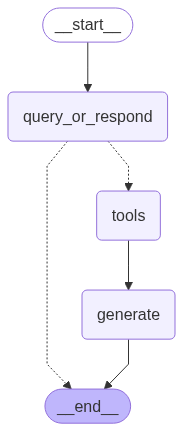

In [91]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)

graph_builder.add_node(ToolNode(tools))
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
graph

# usage

In [111]:
input_message = "سلام"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

سلام
================================== Ai Message ==================================
Tool Calls:
  retrieve (25be6201-e31c-47ee-89b8-b2be69a1ae6f)
 Call ID: 25be6201-e31c-47ee-89b8-b2be69a1ae6f
  Args:
    input_query: meaning of سلام
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'sample_data/salamat/سرپایی.docx', 'file_id': 'file-eef26790060443268YU5lP', 'pk': 458266833003756400}
Content: سرپایی

پرسش:

شریک کاری (آزمایشگاه) در زمان ارسال نسخه های بیمه سلامت برای سازمان در سامانه نسخه نویسی متوجه شدند چند عدد از نسخه های روز گذشته در سیستم ننشسته است، علت چیست؟

پاسخ:

نیاز به بررسی از طریق تماس با مرکز1666می باشد .

پرسش:

آیا امکان افزایش سقف خدمت در شرایط خاص وجود دارد؟ چگونه؟

پاسخ:

قابلیت افزایش سقف خدمات در سامانه الکترونیک وجود دارد. برخی از خدمات با توجه به استانداردهای ابلاغی از وزارت بهداشت دارای سقف هستند در برخی موارد پزش

In [104]:
input_message = "sleeve gastrectomy"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

sleeve gastrectomy
================================== Ai Message ==================================
Tool Calls:
  retrieve (3cedc0a5-6a47-4c57-b741-7fed26755e3b)
 Call ID: 3cedc0a5-6a47-4c57-b741-7fed26755e3b
  Args:
    input_query: sleeve gastrectomy
================================= Tool Message =================================
Name: retrieve

Source: {'file_id': 'file-899305c3d2bc4715MoHGS7', 'source': 'sample_data/salamat/بستری.docx', 'pk': 458266833003756528}
Content: پرسش:

آیاعمل اسلیو معده در تعهد سازمان است؟

پاسخ:

 در بیماران عادی  BMI مساوی و یا بالای 40  که جنبه درمانی داشته باشد. 
 در بیمار ان دیابتی  دارای چاقی35= BMI کفایت میکند.


پرسش:

آیا عمل لوزه سوم تحت پوشش بیمه است؟

پاسخ:

بله_x000D_


پرسش:

آیا عمل دیسک کمر در تعهد بیمه است ؟

پاسخ:

بله_x000D_


پرسش:

آیا عمل لیزیک چشم در تعهد بیمه است ؟

پاسخ:

خیر_x000D_


پرسش:

آیا عمل فتخ ناف در تعهد بیمه می یاشدو نیاز به تایید دارد؟

پ

In [92]:
input_message = "رادیولوژی  تحت پوشش بیمه قرار میگیرد؟"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

رادیولوژی  تحت پوشش بیمه قرار میگیرد؟
================================== Ai Message ==================================
Tool Calls:
  retrieve (d15d2dae-26ae-4345-a062-dd795fb57518)
 Call ID: d15d2dae-26ae-4345-a062-dd795fb57518
  Args:
    input_query: آیا رادیولوژی تحت پوشش بیمه قرار میگیرد؟
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'sample_data/salamat/صعب العلاج.docx', 'file_id': 'file-a22847f4f7564623I3iqq2', 'pk': 458266833003756485}
Content: پاسخ:

  خیر. رادیوتراپی از تعهدات بیمه حذف نشده است در صورت داشتن نشان بیماری صعب العلاج در مراکز دولتی رایگان و در مراکز غیر دولتی علاوه بر سهم بیمه پایه حداکثر معادل 100درصد تعرفه دولتی نیز از محل صندوق با رعایت ضوابط قابل محاسبه و پرداخت است    
در صورت هرگونه ابهام و به منظور پیگیری بیشتر با در دست داشتن مدارک و مستندات به ادارات کل بیمه سلامت استان مراجعه نمایند.

پرسش:

آیا کمک هزین

In [95]:
input_message = "تعهدات ivf چجوریه؟"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

تعهدات ivf چجوریه؟
================================== Ai Message ==================================
Tool Calls:
  retrieve (4a29c7b9-b959-49f3-a1e1-07afa6139cf1)
 Call ID: 4a29c7b9-b959-49f3-a1e1-07afa6139cf1
  Args:
    input_query: تعهدات ivf
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'sample_data/salamat/بستری.docx', 'file_id': 'file-899305c3d2bc4715MoHGS7', 'pk': 458266833003756525}
Content: بستری

پرسش:

تعهدات IVF در صندوق های بیمه سلامت در مراکز طرف قرارداد و غیر طرف قرارداد به چه صورت می باشد ؟

پاسخ:

1-در مراکز دولتی با90% تعرفه مصوب بخش دولتی 2- در مراکز عمومی غیردولتی با 90%تعرفه مصوب بخش عمومی غیردولتی 3- درمراکز خصوصی وخیریه با 70% تعرفه مصوب بخش خصوصی وخیریه می توانند از 4 بسته خدمتی استفاده نمایند.

پرسش:

 فرانشیز خدمات بستری جهت مددجویان بهزیستی و کمیته امداد و همچنین روستاییان با رعایت نظام ارجاع صفر می باشد آیا ای

In [96]:
input_message = "هزینه اقامت به چه صورته؟"
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

هزینه اقامت به چه صورته؟
================================== Ai Message ==================================
Tool Calls:
  retrieve (5824a785-ce23-44de-bf53-31d483292ccd)
 Call ID: 5824a785-ce23-44de-bf53-31d483292ccd
  Args:
    input_query: هزینه اقامت
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'sample_data/salamat/بستری.docx', 'file_id': 'file-899305c3d2bc4715MoHGS7', 'pk': 458266833003756526}
Content: پرسش:

هزینه اقامت (هتلینگ) اعلام شده در خصوص خدمات بستری به ازای هر شب بستری شدن بیمه شده می باشد یا برای کل دوران بستری محاسبه می شود؟

پاسخ:

 هزینه هتلینگ  بر اساس مصوبات سالیانه اعلامی هیأت محترم وزیران، به ازای هر شب بستری مشروط به اقامت بیش از 6 ساعت  و بر اساس درجه اعتباربخشی بیمارستان محاسبه می‌گردد.

پرسش:

با توجه جدول هزینه اقامت (هتلینگ) در خصوص هزینه همراه آیا برای این ردیف سهم سازمان نیز لحاظ می گردد یا اینکه هزینه همراه

In [9]:
input_message = "can you tell me what is task decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what is task decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3e5ef5fb-53bb-4cd9-ba8b-3fbcab3f6f65)
 Call ID: 3e5ef5fb-53bb-4cd9-ba8b-3fbcab3f6f65
  Args:
    input_query: task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple 

# dummy test

In [10]:
from typing import List

from langchain_core.tools import tool
from langchain_ollama import ChatOllama


@tool
def validate_user(user_id: int, addresses: List[str]) -> bool:
    """Validate user using historical addresses.

    Args:
        user_id (int): the user ID.
        addresses (List[str]): Previous addresses as a list of strings.
    """
    return True

In [14]:
model = "qwen3:32b"

llm = ChatOllama(
    model=model,
    base_url=base_url,
    temperature=0,
).bind_tools([validate_user])

result = llm.invoke(
    "Could you validate user 123? They previously lived at "
    "123 Fake St in Boston MA and 234 Pretend Boulevard in "
    "Houston TX."
)
result.tool_calls

[{'name': 'validate_user',
  'args': {'addresses': ['123 Fake St in Boston MA',
    '234 Pretend Boulevard in Houston TX'],
   'user_id': 123},
  'id': '72c37943-3b50-43cc-9d30-d351ecbf245f',
  'type': 'tool_call'},
 {'name': 'validate_user',
  'args': {'addresses': ['123 Fake St in Boston MA',
    '234 Pretend Boulevard in Houston TX'],
   'user_id': 123},
  'id': 'e122b6e0-c3e1-495e-aab6-5da74ebf30f2',
  'type': 'tool_call'}]

In [16]:
model = "gemma3:27b"
llm = ChatOllamaCustomized(
    model=model,
    base_url=base_url,
    temperature=0,
).bind_tools([validate_user])

result = llm.invoke(
    "Could you validate user 123? They previously lived at "
    "123 Fake St in Boston MA and 234 Pretend Boulevard in "
    "Houston TX."
)
result.tool_calls

[{'name': 'validate_user',
  'arguments': {'user_id': 123,
   'addresses': ['123 Fake St, Boston MA',
    '234 Pretend Boulevard, Houston TX']},
  'id': '75420c37-7243-4f21-928e-d2a69e650dd8',
  'type': 'tool_call'}]

# test milvus client